In [1]:
# import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
import sys
from csv import excel
from scipy import stats

path='../save_outputs/vol-vfd'
task_cnt = 8

# fsim = f'{path}/hm-sim.f100.n{task_cnt}.r100.log.xlsx'
# fagg = f'{path}/hm-agg.f100.n{task_cnt}.r100.log.xlsx'

fvolsim=f'{path}/prov-vfd-sim-vol.csv'
fvfdsim=f'{path}/prov-vfd-sim-vfd.csv'

fvolsim=f'{path}/prov-vfd-agg-vol.csv'
fvfdsim=f'{path}/prov-vfd-agg-vfd.csv'

In [2]:
# data related methods
def humansize(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1000 and i < len(suffixes)-1:
        nbytes /= 1000.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

def check_empty(df,p=True):
    nan_df = df[df.isna().any(axis=1)].copy()
    if not nan_df.empty:
        if p:
            print(f"NaN rows: {nan_df}") # check any nan
        return list(nan_df.index)
    
    null_df = df[df.isnull().any(axis=1)].copy()
    if not null_df.empty:
        if p:
            print(f"NULL rows: {null_df}") # check any null
        return list(null_df.index)
    
def print_list_diff(list1, list2):
    if list1 == list2:
        print("same lists")
    else:
        print("different lists\nindex:\t[list1]\t[list2]")
        for index, (first, second) in enumerate(zip(list1, list2)):
            if first != second:
                # print(index, first, second)
                print(f"{index}:\t{first}]\t[{second}]")

def df_to_csv(df,file_name,suffix=''):
    # df.hash_id=df.hash_id.astype('category').cat.codes
    # out_csv=file_name.replace('prov-vfd-','')
    out_csv=file_name.replace('.csv',f'{suffix}.csv')
    df.to_csv(out_csv,index=False)
    
def read_data(filename, dset=''):
    if '.parquet' in filename:
        df = pd.read_parquet(filename,engine='pyarrow')
    if'.csv' in filename:
        df = pd.read_csv(filename,index_col=False)
    
    if len(dset) > 0:
        df = df[df['dset_name'] == dset]
        
    return df

In [3]:
# networkx related methods
from collections import Counter

color_map = {"task": "#ab2626", # read
            "data_label_vol": "#fc8403", #orange
            "data_label_vfd": "#3879cf", # blue
            "logical_addr": "#69b3d6", #light blue
            "logical_addr_vfd": "#719ed9", # slightly different light lue
            "file": "#154c79", # dark blue
            "read": "#bf7777", # light read
            "write": "#b277bf", #light purpul
            "none": "grey",
            }

def draw_graph(G,color_map, rm_tags=['']):
    pos=nx.get_node_attributes(G,'pos')
    names = nx.get_node_attributes(G,'name')

    node_colors = [] 
    # set node colors
    for name in names.values():
        node_colors.append(color_map[name])
        
    # set node labels
    labels = {}
    for node in names.keys():
        _n = node
        for t in rm_tags:
            _n = str(_n).replace(f"{t}-","")
            _n = str(_n).replace("vol-","")
            _n = str(_n).replace("contact_map","cp")
            _n = str(_n).replace("point_cloud","pc")
            
        if 'addr' in names[node]:
            labels[node] = f'addr : {_n}'
        else:
            labels[node] = _n

    
    plt.figure(figsize=(25, 10)) #figsize=(40, 10)
    
    bbox = dict(alpha=0.6, fc="black", ec="white", boxstyle="square", color='white') #fc="red", , lw=3
        
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, labels= labels, bbox=bbox, horizontalalignment='left', font_color='white')
    
    for edge in G.edges(data='weight'):
        nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=edge[2], )
    
    plt.axis("off")
    plt.margins(x=0.1)
    plt.show()

def get_graph(in_df, cols, source='task', sink='output', tag='', x=0, reverse=False):
    _x = x
    G = nx.DiGraph()
    # G = nx.MultiDiGraph()
    if '.h' in source:
        G.add_node(source,pos=(_x,0),name="file")
    else:
        G.add_node(source,pos=(_x,0),name="task")
    df = pd.DataFrame(columns=cols)
    for c in cols:
        df[c] = f'{tag}-' + in_df[c].astype(str)
    
    for c in cols:
        vals = list(df[c])
        _x +=1
        _y = -1
        
        # create address position list
        if 'addr' in c:
            org_vals = list(in_df[c])
            _addr_pos = stats.rankdata(org_vals,method='dense')
            
        # for i in range(0,len(vals)):
        for i, v in enumerate(vals):
            
            if(G.has_node(v) == False):
                _y +=1
                if 'addr' in c:
                    G.add_node(v,pos=(_x,_addr_pos[i]),name=f'{c}')
                else:
                    G.add_node(v,pos=(_x,_y),name=f'{c}')
            
            if reverse:
                if 'vol' in c: G.add_edge(vals[i], sink, weight=1) 
                elif 'addr' in c: G.add_edge(source, vals[i], weight=1)
            else:
                if 'vol' in c: G.add_edge(source, v, weight=1)
                elif 'addr' in c: G.add_edge(v, sink, weight=1)
    
    for i in range(1, len(cols)):
        two_cols = [cols[i-1],cols[i]]
        _l1 = df[cols[i-1]]
        _l2 = df[cols[i]]
        
        # list(zip(*[tmp_df[col] for col in tmp_df]))
        edges = list(zip(_l1, _l2)) #[tuple(r) for r in newdf[cols].to_list()]
        weights = Counter(edges)
        _w = []
        for e in edges:
                _w.append(weights[e])
        edges_w_weights = list(zip(_l1, _l2, _w))
        # print(edges_w_weights)
        G.add_weighted_edges_from(edges_w_weights)
    _x +=1
    if '.h' in sink:
        G.add_node(sink,pos=(_x,0),name="file")
    else:
        G.add_node(sink,pos=(_x,0),name="task")
    
    x = _x
    
    return G

In [4]:
def merge_df_sim(dfvol, dfvfd):
    df_sim2vol = dfvol[['data_label', 'io_access_idx','dset_name', 'access_size', 'op_type', 'logical_addr']].copy()
    vol_idx2addr_map = dict(zip(df_sim2vol['data_label'], df_sim2vol['logical_addr']))
    
    # df_sim2vol['logical_addr'] = df_sim2vol['logical_addr'].replace(-1,0)
    
    df_sim2vol['logical_addr_map'] = df_sim2vol['logical_addr'].astype(int)

    df_vfd2res = dfvfd[['data_label', 'file_name', 'access_size', 'op_type','start_addr']].copy()
    # df_vol2res.rename(columns={'start_addr':'logical_addr'}, inplace=True)
    df_vfd2res['start_addr'] = df_vfd2res['start_addr'].fillna(0)
    df_vfd2res['logical_addr_map'] = df_vfd2res['start_addr'].astype(int)
    
    # modify all meta mapping address to 0
    df_sim2vol.loc[df_sim2vol['op_type'] == 'meta', 'logical_addr_map'] = 0
    df_vfd2res.loc[df_vfd2res['op_type'] == 'meta', 'logical_addr_map'] = 0
    
    df_vfd2res.rename(columns={'start_addr':'logical_addr_vfd'}, inplace=True)
    df_merged = df_sim2vol.merge(df_vfd2res, how='inner', on=['logical_addr_map'], suffixes=['_vol','_vfd'])

    # populate file_name
    df_merged['file_name'] = df_merged['file_name'].fillna('task0000/residue_100.h5')

    
    
    return df_merged, vol_idx2addr_map

fsim_vol='../save_outputs/vol-vfd/prov-vfd-sim-vol.csv'
fsim_vfd='../save_outputs/vol-vfd/prov-vfd-sim-vfd.csv'

df_sim_vol = read_data(fsim_vol)
df_sim_vfd = read_data(fsim_vfd)

# print(df_sim_vfd['start_addr'])

# # print(df_sim_vol.head(3))
df_merged, vol_idx2addr_map = merge_df_sim(df_sim_vol,df_sim_vfd)

# # print(df_merged.head(10))
# # df_merged.rename(columns={'io_access_idx_vol':'vol_idx', 'logical_addr':'access'}, inplace=True)
print(df_merged.columns)
# print(df_merged.tail(5))
# print(df_merged[df_merged['data_label_vol'].str.contains('meta-point_cloud')]) 

Index(['data_label_vol', 'io_access_idx', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr', 'logical_addr_map', 'data_label_vfd',
       'file_name', 'access_size_vfd', 'op_type_vfd', 'logical_addr_vfd'],
      dtype='object')


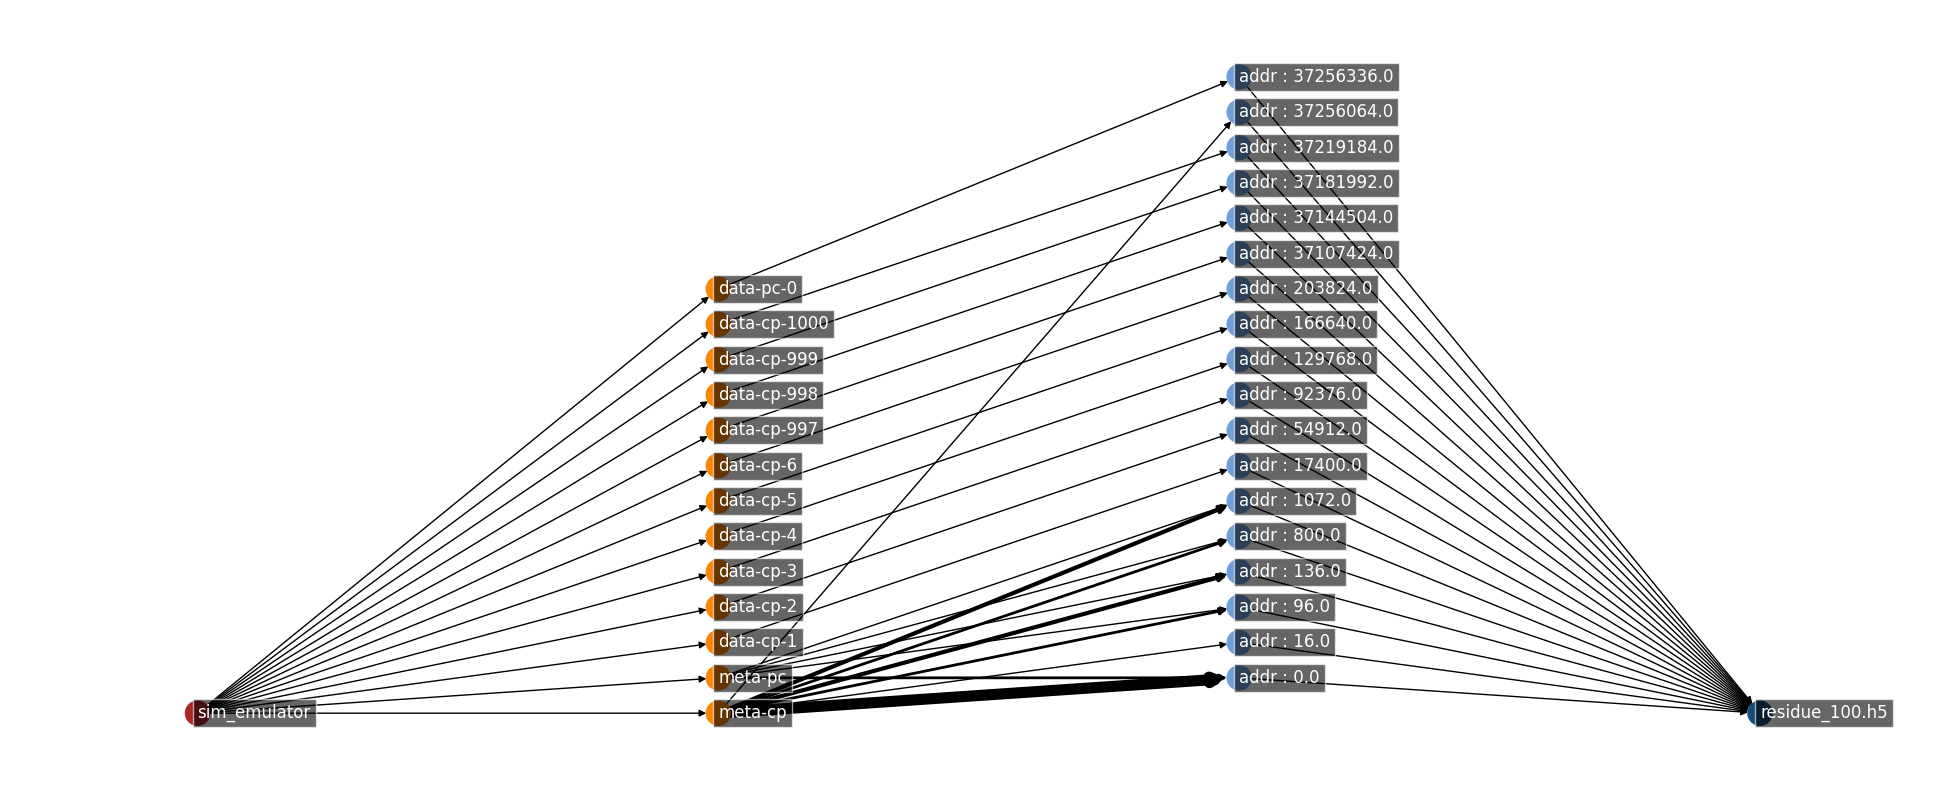

In [5]:
# print(df_merged[df_merged['data_label_vol'].str.match('vol-data-contact_map-1')])

df_show = pd.concat([df_merged.head(20),df_merged.iloc[175:181], df_merged.iloc[443:449],df_merged.tail(5)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr'
G_SIM = get_graph(df_show,['data_label_vol', 'logical_addr_vfd'], source='sim_emulator', sink='residue_100.h5',tag='sim')

# print(pos)
draw_graph(G_SIM,color_map,rm_tags=['sim'])

In [6]:
# map only read
def merge_df_agg_read(dfvol, dfvfd,vol_idx2addr_map):
    df_agg2vol = dfvol[['data_label', 'io_access_idx','dset_name', 'access_size', 'op_type','logical_addr']].copy()
    df_vfd2res = dfvfd[['data_label', 'io_access_idx','file_name', 'access_size', 'op_type','next_addr','start_addr']].copy()

    # df_agg2vol['logical_addr'] = df_agg2vol['logical_addr'].astype(int)
    
    # address map for vol
    df_agg2vol['logical_addr_map'] = df_agg2vol['data_label'].map(vol_idx2addr_map)
    df_agg2vol.loc[df_agg2vol['op_type'] == 'meta', 'logical_addr_map'] = 0 # all meta map to 0
    
    # split by op_type
    df_vfd2res_meta = df_vfd2res[df_vfd2res['op_type'] == 'meta'].copy() # use 0 for meta
    df_vfd2res_loc = df_vfd2res[df_vfd2res['op_type'] == 'loc'].copy() # this match vol with start_addr
    df_vfd2res_data = df_vfd2res[df_vfd2res['op_type'] == 'data'].copy() # this match loc with next_addr
    
    # address map for vfd-meta
    df_vfd2res_meta['logical_addr_map'] = 0
    df_vfd2res_loc['logical_addr_map'] = df_vfd2res_loc['start_addr']
    
    # address map for vfd-data
    df_vfd2res_data_map  = dict(zip(df_vfd2res_loc['next_addr'], df_vfd2res_loc['start_addr']))
    df_vfd2res_data['logical_addr_map'] = df_vfd2res_data['start_addr'].map(df_vfd2res_data_map)
    
    nan_idx = check_empty(df_vfd2res_data,p=False)
    for idx in nan_idx:
        df_vfd2res_data.loc[idx, ['logical_addr_map']] = df_vfd2res.iloc[idx]['start_addr']
    
    # # rename and conver types
    # df_vol2res_meta['logical_addr_map'] = df_vol2res_meta['start_addr']
    # df_vol2res_loc['logical_addr_map'] = df_vol2res_loc['start_addr']
    
    df_vfd2res = pd.concat([df_vfd2res_meta,df_vfd2res_loc, df_vfd2res_data], axis=0).set_index('io_access_idx')

    # # df_vol2res_data['logical_addr_map'] = df_vol2res_data['logical_addr_map'].astype(int)
    df_vfd2res.rename(columns={'start_addr':'logical_addr'}, inplace=True)
    df_vfd2res['logical_addr'] = df_vfd2res['logical_addr'].replace(-1,0)
    
    df_merged = df_agg2vol.merge(df_vfd2res, how='inner', on=['logical_addr_map'], suffixes=['_vol','_vfd'])
    
    return df_merged

dfvol='../save_outputs/vol-vfd/prov-vfd-agg-vol-read.csv'
dfvfd='../save_outputs/vol-vfd/prov-vfd-agg-vfd-read.csv'

dfvol = read_data(dfvol)
dfvfd = read_data(dfvfd)

df_agg_read_merged = merge_df_agg_read(dfvol,dfvfd,vol_idx2addr_map)

# print(df_agg_read_merged.head(20))

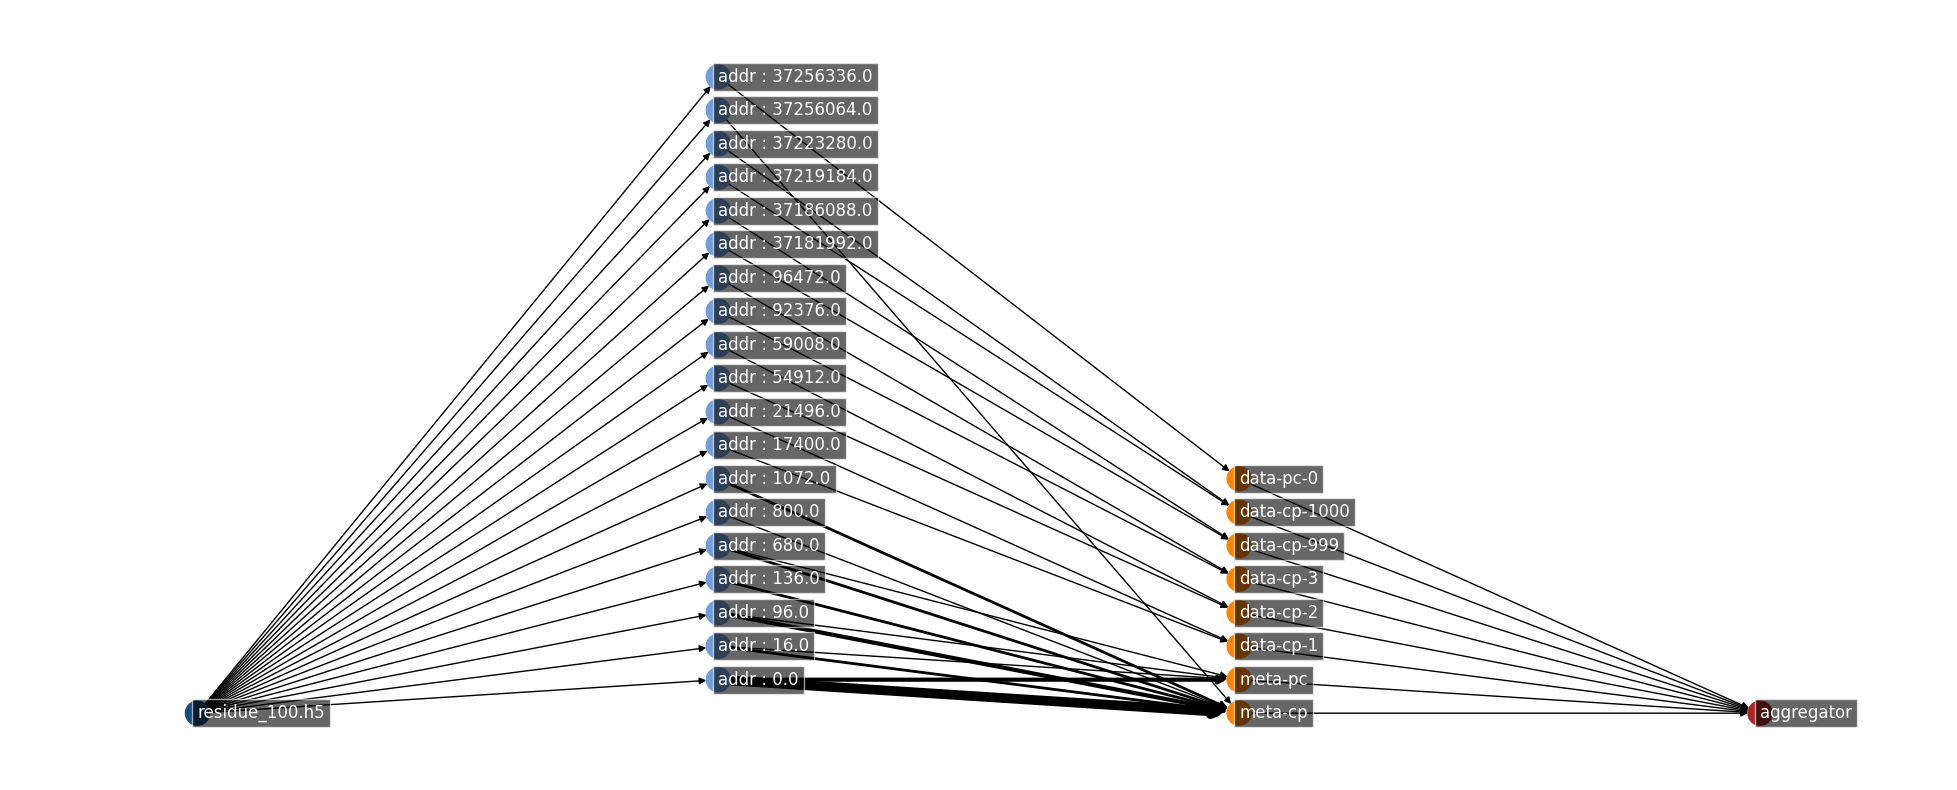

In [7]:
# print(df_agg_read_merged[df_agg_read_merged['data_label_vol'].str.match('vol-data-contact_map-1')])
# print(df_agg_read_merged[df_agg_read_merged['data_label_vol'].str.match('vol-meta-point_cloud')])

df_show = pd.concat([df_agg_read_merged.head(20),df_agg_read_merged.iloc[195:201], df_agg_read_merged.iloc[391:397],df_agg_read_merged.tail(5)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr_vfd'
x_pos = max(nx.get_node_attributes(G_SIM,'pos').values())[0]

G_AGG_R = get_graph(df_show,['logical_addr_vfd', 'data_label_vol'], source='residue_100.h5', sink='aggregator',tag='agg_r',x=x_pos, reverse=True)
draw_graph(G_AGG_R,color_map, rm_tags=['agg_r'])

In [8]:
# map only write
def apply_map(x,df_vfd2res_data):
    newdf = pd.DataFrame()
    if x.name == 'loc':
        df_vfd2res_loc_map  = dict(zip(df_vfd2res_data['data_label'], df_vfd2res_data['start_addr']))
        newdf['loc_map'] = x['data_label'].map(df_vfd2res_loc_map)
    return newdf
        

def merge_df_agg_write(dfvol, dfvfd):
    df_agg2vol = dfvol[['data_label','dset_name', 'access_size','op_type', 'logical_addr']].copy()
    df_vol2vfd = dfvfd[['data_label', 'io_access_idx', 'file_name', 'access_size', 'start_addr', 'next_addr','op_type']].copy()

    # vol map # set 0 for meta
    df_agg2vol['logical_addr_map'] = df_agg2vol['logical_addr'].astype(int)
    df_agg2vol.loc[df_agg2vol['op_type'].str.match('meta'), 'logical_addr_map'] = 0
    
    # data map
    df_vfd2res_data = df_vol2vfd[df_vol2vfd['op_type'] == 'data'].copy()
    df_vfd2res_data['logical_addr_map'] = df_vfd2res_data['start_addr'].astype(int)
    # modify point_cloud to use only 1 address for mapping 
    idx_pc = df_agg2vol.data_label.str.match(f'vol-data-point_cloud-0').idxmax()
    PC_START_ADDR = int(df_agg2vol.iloc[idx_pc]['logical_addr'])
    df_vfd2res_data.loc[df_vfd2res_data['data_label'].str.contains('point_cloud'), 'logical_addr_map'] = PC_START_ADDR
    
    # loc maps by data_label 
    df_vfd2res_loc = df_vol2vfd[df_vol2vfd['op_type'] == 'loc'].copy()
    vfd2res_loc_map  = dict(zip(df_vfd2res_data['data_label'], df_vfd2res_data['start_addr']))
    df_vfd2res_loc['logical_addr_map'] = df_vfd2res_loc['data_label'].map(vfd2res_loc_map)
    
    # lheap maps by address
    df_vfd2res_lheap = df_vol2vfd[df_vol2vfd['op_type'] == 'lheap'].copy()
    vfd2res_lheap_map = dict(zip(df_vfd2res_data['start_addr'], df_vfd2res_data['next_addr']))
    df_vfd2res_lheap['logical_addr_map'] = df_vfd2res_lheap['next_addr'].map(vfd2res_lheap_map)
    
    # meta maps to 0
    df_vfd2res_meta = df_vol2vfd[df_vol2vfd['op_type'] == 'meta'].copy()
    df_vfd2res_meta['logical_addr_map'] = 0
    
    df_vfd2res = pd.concat([df_vfd2res_data,df_vfd2res_loc,df_vfd2res_lheap,df_vfd2res_meta], axis=0) #.set_index('io_access_idx')
    df_vfd2res = df_vfd2res.rename(columns={'start_addr':'logical_addr'})
    df_merged = df_agg2vol.merge(df_vfd2res, how='inner', on=['logical_addr_map'], suffixes=['_vol','_vfd'])

    # populate file_name
    df_merged['file_name'] = df_merged['file_name'].fillna('aggregate.h5')
    
    return df_merged


fagg_vol_write='../save_outputs/vol-vfd/prov-vfd-agg-vol-write.csv'
fagg_vfd_write='../save_outputs/vol-vfd/prov-vfd-agg-vfd-write.csv'
dfvol = read_data(fagg_vol_write)
dfvfd = read_data(fagg_vfd_write)
df_agg_write_merged = merge_df_agg_write(dfvol,dfvfd)

print(df_agg_write_merged.columns)
# print(df_agg_write_merged.head(20))

Index(['data_label_vol', 'dset_name', 'access_size_vol', 'op_type_vol',
       'logical_addr_vol', 'logical_addr_map', 'data_label_vfd',
       'io_access_idx', 'file_name', 'access_size_vfd', 'logical_addr_vfd',
       'next_addr', 'op_type_vfd'],
      dtype='object')


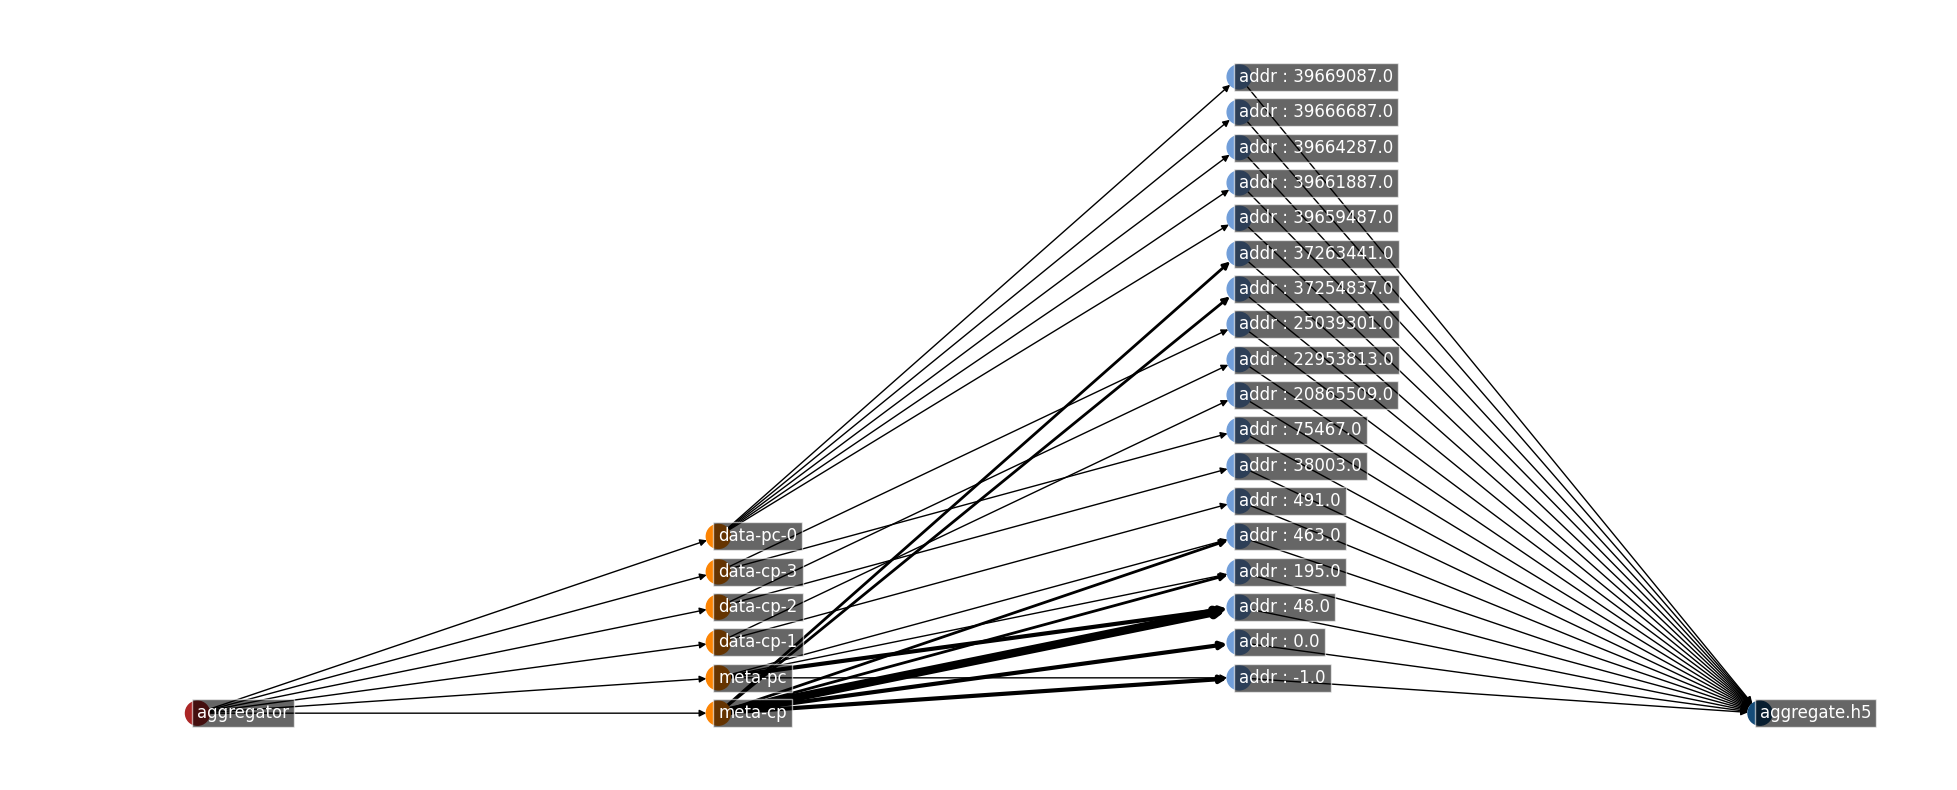

In [9]:
# print(df_agg_write_merged[df_agg_write_merged['data_label_vol'].str.match('vol-data-contact_map-1')])
# print(df_agg_write_merged[df_agg_write_merged['data_label_vol'].str.match('vol-meta-point_cloud')])

df_show = pd.concat([df_agg_write_merged.head(20),df_agg_write_merged.iloc[88:94], df_agg_write_merged.iloc[233:239],df_agg_write_merged.tail(5)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr'
x_pos = max(nx.get_node_attributes(G_AGG_R,'pos').values())[0]
G_AGG_W = get_graph(df_show,['data_label_vol', 'logical_addr_vfd'], source='aggregator', sink='aggregate.h5',tag='agg_w',x=x_pos)
draw_graph(G_AGG_W,color_map,rm_tags=['agg_w'])

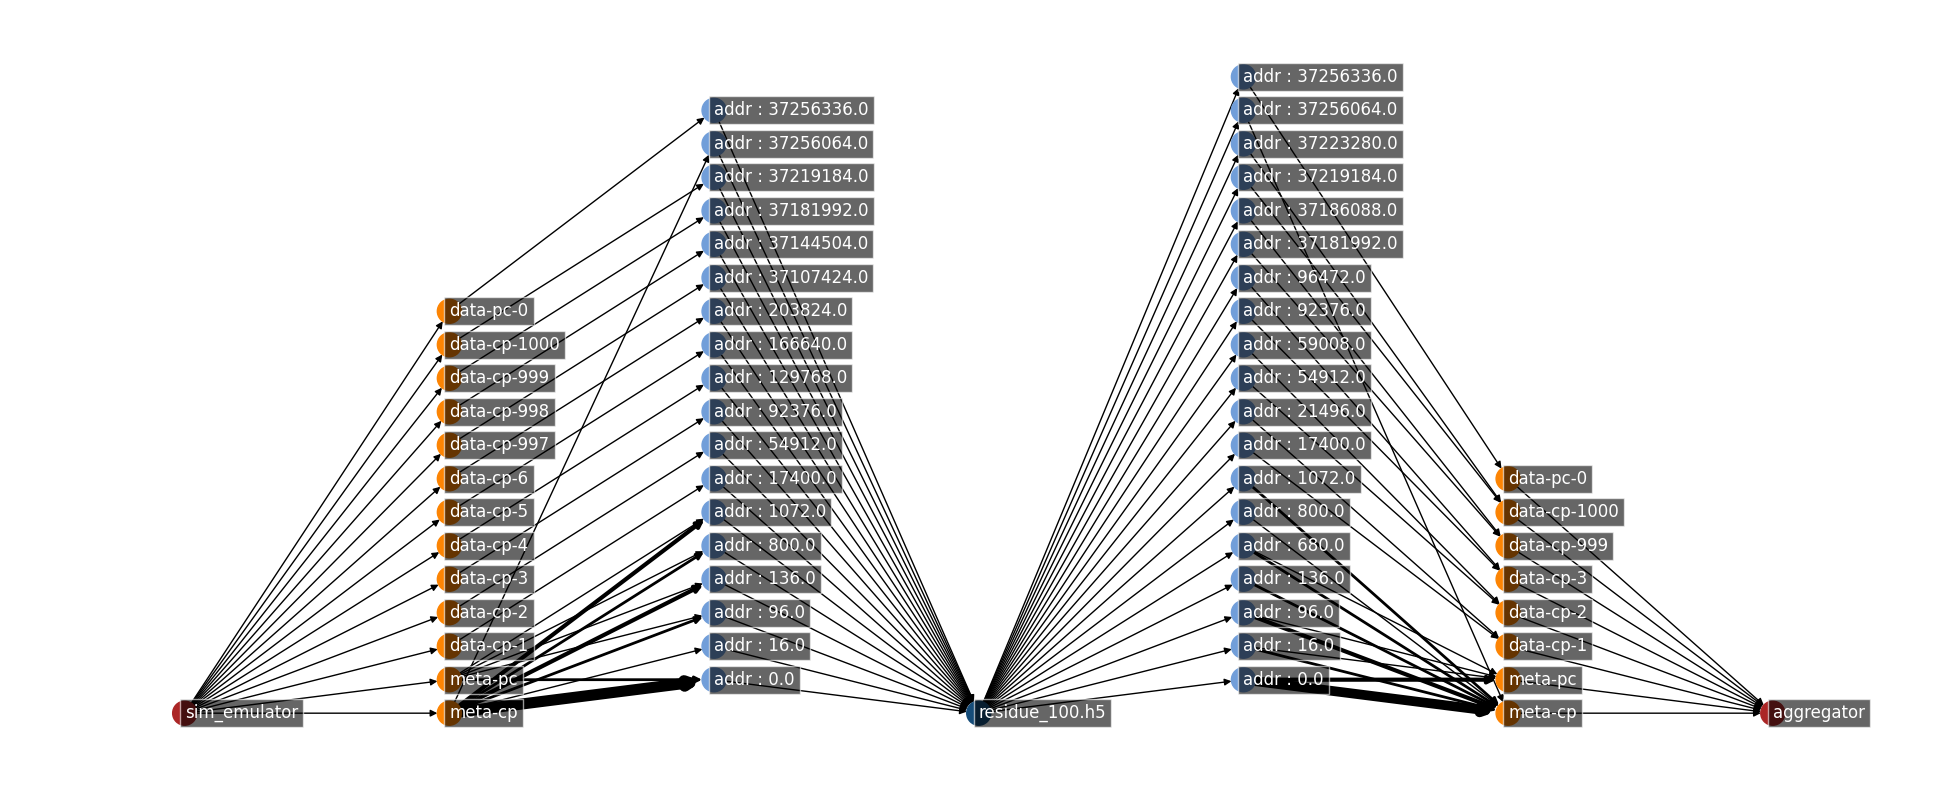

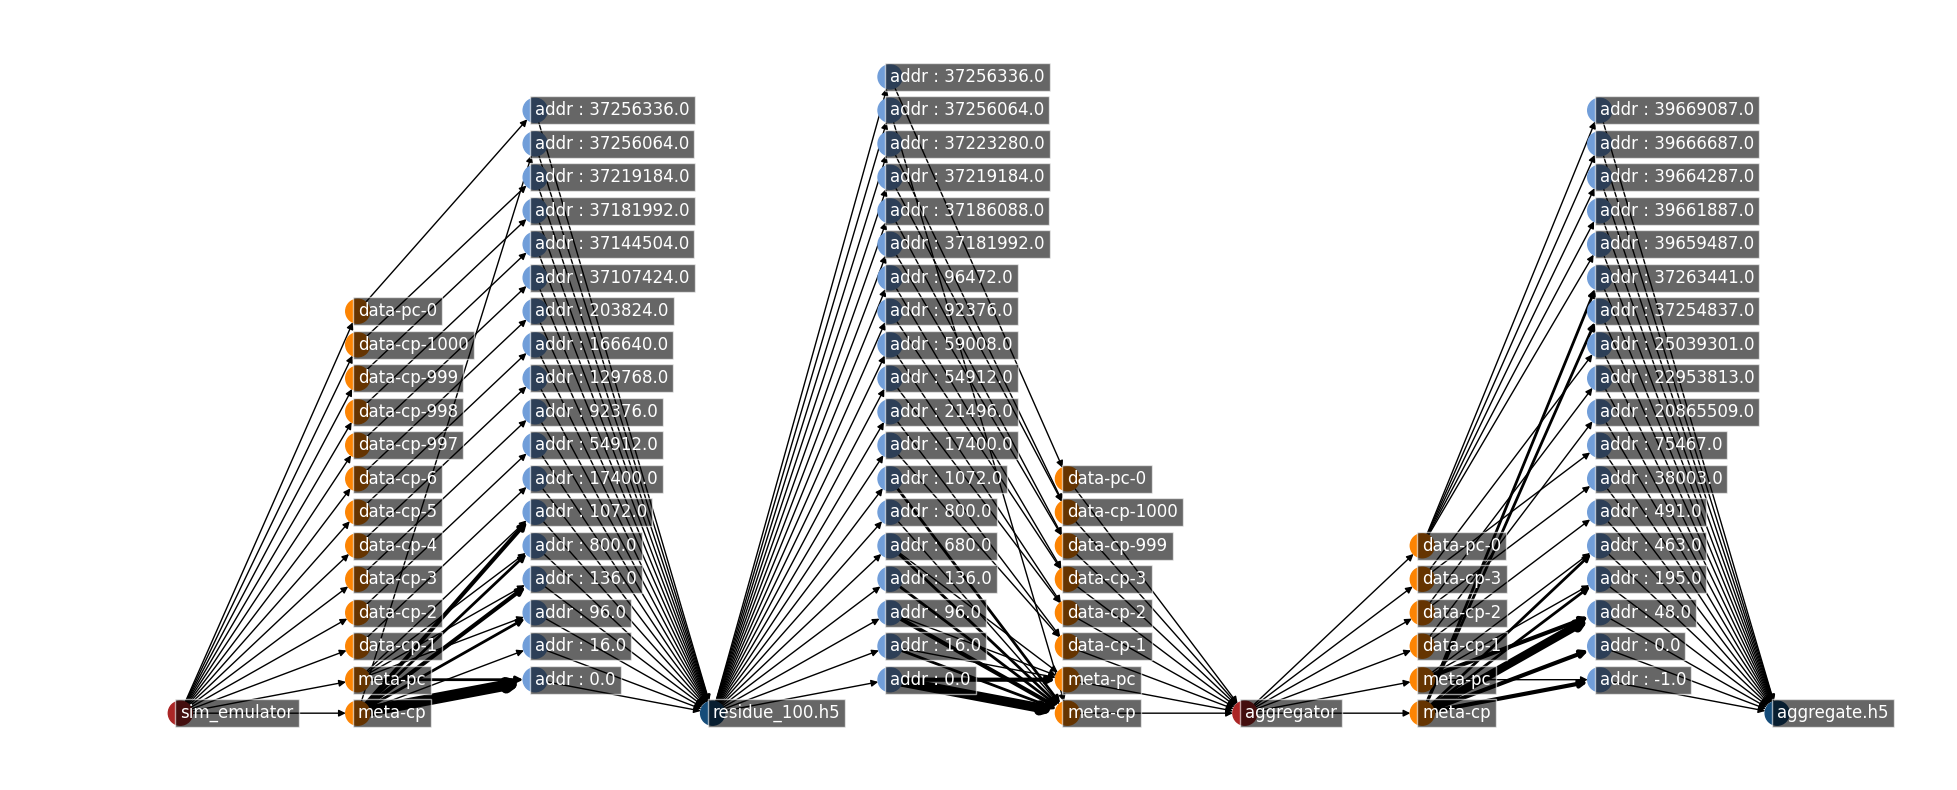

In [10]:
F1 = nx.compose(G_SIM,G_AGG_R)
draw_graph(F1,color_map,rm_tags=['sim','agg_r'])

F2 = nx.compose(F1, G_AGG_W)
draw_graph(F2,color_map,rm_tags=['sim','agg_r','agg_w'])